In [1]:
import tensorflow as tf
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.backends.backend_pdf
#import seaborn as sns
from os.path import join, os
from scipy import stats
from sklearn.svm import SVR, SVC
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest, chi2, SelectPercentile
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
import time as tm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import _pickle as cPickle
from scipy.stats import pearsonr

In [2]:
# RTDB 경로
RTDB_path = r'.\RTDB\RTDB.csv'
data_dir = r'.\analysis'

In [2]:
def DrawTimePlot(x,y, title):
    fig = plt.figure()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()
    
    # Add axis labels
    plt.xlabel('time')
    plt.ylabel('2nd.bz.max.temp')
    plt.title(title)

    plt.plot(x,y)
    #fig.savefig(join(data_dir,title + '.pdf'))

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
def getDataFrame(path):
    df = pd.read_csv(path, index_col=0)
    return df

In [5]:
def strtodate(date_arr):
    x = [dt.datetime.strptime(d,'%Y-%m-%d %H:%M') for d in date_arr]
    return x

In [6]:
def RemoveLowerOut(df,column_name):
    deout_df = df[(stats.zscore(df[column_name]) > -3)]
    return deout_df

In [7]:
if __name__ == "__main__":
    RTDB = getDataFrame(RTDB_path)
    RTDB = RTDB.drop(['Catalyst_V3_front_cl Content', 'Catalyst_V3_back_cl Content'],1)

    # What is the more userful?
    
    date = strtodate(RTDB.index)
    max_2nd_bz = RTDB['max_2nd.Burning.Zone']
    #max_2nd_bz = np.array(RTDB['max_2nd.Burning.Zone'])

NameError: name 'RTDB_path' is not defined

In [8]:
RTDB = RemoveLowerOut(RTDB,'max_2nd.Burning.Zone')

date = strtodate(RTDB.index)
max_2nd_bz = RTDB['max_2nd.Burning.Zone']

#DrawTimePlot(date,max_2nd_bz, 'Remove outlier max temp plot')

NameError: name 'RTDB' is not defined

In [89]:
idx_RTDB = RTDB.reset_index() # Remove NaN row


x_RTDB = idx_RTDB.drop(['max_2nd.Burning.Zone', 'max_2nd.1dan', 'max_2nd.2dan', 
                         'max_2nd.3dan', 'max_2nd.4dan', 'max_2nd.5dan', 'index'],1)
idx_RTDB = idx_RTDB.drop(['max_2nd.1dan', 'max_2nd.2dan', 
                         'max_2nd.3dan', 'max_2nd.4dan', 'max_2nd.5dan', 'index'],1)

x_RTDB = x_RTDB[:len(x_RTDB)-120]
idx_RTDB = idx_RTDB[:len(idx_RTDB)-120]

train_x = x_RTDB.loc[1:(len(idx_RTDB)*4/5)]
train_y = idx_RTDB.loc[1:(len(idx_RTDB)*4/5),['max_2nd.Burning.Zone']]

test_x = x_RTDB.loc[(len(idx_RTDB)*4/5):]
test_y = idx_RTDB.loc[(len(idx_RTDB)*4/5):, ['max_2nd.Burning.Zone']]

short_x = x_RTDB.loc[1:(len(idx_RTDB)*1/5)]
short_y = idx_RTDB.loc[1:(len(idx_RTDB)*1/5),['max_2nd.Burning.Zone']]

short_x_t = x_RTDB.loc[(len(idx_RTDB)*1/5):(len(idx_RTDB)*6/25)]
short_y_t = idx_RTDB.loc[(len(idx_RTDB)*1/5):(len(idx_RTDB)*6/25),['max_2nd.Burning.Zone']]

dnn_train_x = idx_RTDB.loc[:(len(idx_RTDB)*4/5)]
dnn_train_x.columns = [col.replace(' ', '_') for col in dnn_train_x.columns]
dnn_train_y = idx_RTDB.loc[(len(idx_RTDB)*4/5):]
dnn_train_y.columns = [col.replace(' ', '_') for col in dnn_train_x.columns]

train_y_label = pd.DataFrame(train_y['max_2nd.Burning.Zone'].apply(lambda x: 1 if x >=550 else 0))
test_y_label = pd.DataFrame(test_y['max_2nd.Burning.Zone'].apply(lambda x: 1 if x >=550 else 0))
short_y_label = pd.DataFrame(short_y['max_2nd.Burning.Zone'].apply(lambda x: 1 if x >=550 else 0))

In [90]:
scaler = preprocessing.StandardScaler().fit(train_x)
scale_train = scaler.transform(train_x) 
scale_test = scaler.transform(test_x)

scaled_train_df = pd.DataFrame(
    scale_train, index=train_x.index, columns=train_x.columns)

scaled_test_df = pd.DataFrame(
    scale_test, index=test_x.index, columns=test_x.columns)

In [94]:
start_time = tm.time()
clf = SelectKBest( k=21)
X_features = clf.fit(scaled_train_df,train_y)
scaled_train_df = scaled_train_df[scaled_train_df.columns.values[X_features.get_support()]]
scaled_test_df = scaled_test_df[scaled_test_df.columns.values[X_features.get_support()]]
print("SelectKBest feature selection F-test %s seconds ---" % (tm.time() - start_time))
print(scaled_train_df.columns.values[X_features.get_support()])

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectKBest feature selection F-test 0.7840447425842285 seconds ---
['R1_RDT_Total_Feed' 'R2_RDT_T_PAR' 'R2_RDT_Total_Feed' 'R2_RDT_PAR_FEED'
 'R3_RDT_Total_Feed' 'R3_RDT_PAR_FEED' 'R3_RDT_T_PAR' 'R4_RDT_T_ARO'
 'R4_RDT_T_PAR' 'R4_RDT_PAR_FEED' 'R2_RIT_mean' 'R2_RIT_max'
 'Re_Gas_H2_purity' 'C_1_DISCH' 'Re_Gas_MOLAR_RATIO' 'C_1_SUCTION'
 'Catalyst_V3_front_coke Content' 'V-3 1ST BURN ZON E-1 INLET GAS'
 'V-3 1ST BURN ZON H-1 OUTLET' 'Burning Gas C-2 OUT TO V-3'
 'R-3 OUT H-4 IN (R-3 ROT)']


In [95]:
start_time = tm.time()
svr = SVR('rbf', verbose=True)

svr.fit(scaled_train_df, train_y['max_2nd.Burning.Zone'])
print("svr classification termination %s seconds ---" % (tm.time() - start_time))

[LibSVM]svr classification termination 2200.3220496177673 seconds ---


In [96]:
prediction = svr.predict(scaled_test_df)
real = test_y['max_2nd.Burning.Zone']
score = svr.score(scaled_test_df, real)
print(prediction)
print(score)
RMSE = mean_squared_error(real, prediction)**0.5
print(RMSE)

[ 542.97622469  543.36286869  542.84064681 ...,  542.30188686  542.21856202
  542.30111898]
0.169841910635
4.20226968574


In [24]:
r2_score(real, prediction)

-0.49266001846695029

In [97]:
print("MAPE : %.2f%%" %round(mean_absolute_percentage_error(real, prediction),2))

MAPE : 0.56%


In [98]:
pearsonr(real,prediction)

(0.58062800672278236, 0.0)

In [99]:
date_arr = RTDB.reset_index()[:len(RTDB)-120]
test_date = np.array(date_arr.loc[(len(date_arr)*4/5):,'index'])

In [75]:
strtodate(test_date)

[datetime.datetime(2017, 4, 14, 8, 6),
 datetime.datetime(2017, 4, 14, 8, 7),
 datetime.datetime(2017, 4, 14, 8, 8),
 datetime.datetime(2017, 4, 14, 8, 9),
 datetime.datetime(2017, 4, 14, 8, 10),
 datetime.datetime(2017, 4, 14, 8, 11),
 datetime.datetime(2017, 4, 14, 8, 12),
 datetime.datetime(2017, 4, 14, 8, 13),
 datetime.datetime(2017, 4, 14, 8, 14),
 datetime.datetime(2017, 4, 14, 8, 15),
 datetime.datetime(2017, 4, 14, 8, 16),
 datetime.datetime(2017, 4, 14, 8, 17),
 datetime.datetime(2017, 4, 14, 8, 18),
 datetime.datetime(2017, 4, 14, 8, 19),
 datetime.datetime(2017, 4, 14, 8, 20),
 datetime.datetime(2017, 4, 14, 8, 21),
 datetime.datetime(2017, 4, 14, 8, 22),
 datetime.datetime(2017, 4, 14, 8, 23),
 datetime.datetime(2017, 4, 14, 8, 24),
 datetime.datetime(2017, 4, 14, 8, 25),
 datetime.datetime(2017, 4, 14, 8, 26),
 datetime.datetime(2017, 4, 14, 8, 27),
 datetime.datetime(2017, 4, 14, 8, 28),
 datetime.datetime(2017, 4, 14, 8, 29),
 datetime.datetime(2017, 4, 14, 8, 30),
 dat

# SelectKBest Variable selection
['R1_RDT_Total_Feed' 'R2_RDT_T_PAR' 'R2_RDT_Total_Feed' 'R2_RDT_PAR_FEED'
 'R3_RDT_Total_Feed' 'R3_RDT_PAR_FEED' 'R3_RDT_T_PAR' 'R4_RDT_T_ARO'
 'R4_RDT_T_PAR' 'R4_RDT_PAR_FEED' 'R2_RIT_mean' 'R2_RIT_max'
 'Re_Gas_H2_purity' 'C_1_DISCH' 'Re_Gas_MOLAR_RATIO' 'C_1_SUCTION'
 'Catalyst_V3_front_coke Content' 'V-3 1ST BURN ZON E-1 INLET GAS'
 'V-3 1ST BURN ZON H-1 OUTLET' 'Burning Gas C-2 OUT TO V-3'
 'R-3 OUT H-4 IN (R-3 ROT)']

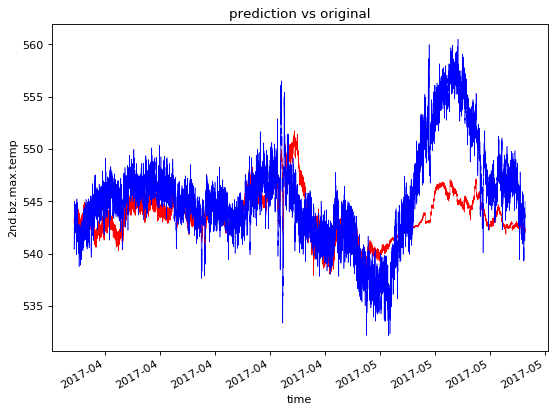

In [100]:
fig = plt.figure(figsize=(8,6), dpi=80)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# Add axis labels
plt.xlabel('time')
plt.ylabel('2nd.bz.max.temp')
plt.title('prediction vs original')

plt.plot(strtodate(test_date), prediction, color="red", linestyle="-",
        linewidth=0.5)
plt.plot(strtodate(test_date), real, color="blue", linestyle="-",
        linewidth=0.5)
plt.show()
#fig.savefig(join(data_dir,title + '.pdf'))

In [104]:
scaled_train_df.columns.values[0]

'R1_RDT_Total_Feed'

# RFECV Variable selection

[R1_RDT_Total_Feed' 'R1_RDT_T_PAR' 'R2_RDT_Total_Feed' 'R3_RDT_Total_Feed'
 'R3_RDT_T_ARO' 'R4_RDT_T_ARO' 'R4_RDT_Total_Feed' 'Re_Gas_H2_purity'
 'R4_New_Wait' 'V-3 1ST BURN ZON E-1 INLET GAS'
 'V-3 1ST BURN ZON H-1 OUTLET' 'Burning Gas C-2 OUT TO V-3'
 'ATMOSPHERE Burning Gas TEMP']

In [106]:
with open(r'C:\Users\Administrator\Desktop\KYJ\coke\real_rfecv.pkl', 'rb') as fid:
    rfecv = cPickle.load(fid)

In [111]:
with open(r'C:\Users\Administrator\Desktop\KYJ\coke\prediction.pkl', 'rb') as fid:
    rfe_prediction = cPickle.load(fid)

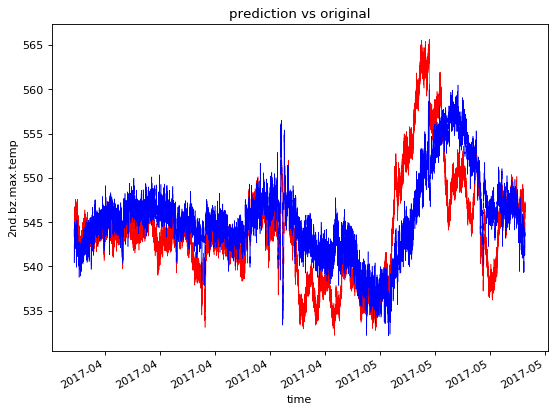

In [112]:
fig = plt.figure(figsize=(8,6), dpi=80)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# Add axis labels
plt.xlabel('time')
plt.ylabel('2nd.bz.max.temp')
plt.title('prediction vs original')

plt.plot(strtodate(test_date), rfe_prediction, color="red", linestyle="-",
        linewidth=0.5)
plt.plot(strtodate(test_date), real, color="blue", linestyle="-",
        linewidth=0.5)
plt.show()
#fig.savefig(join(data_dir,title + '.pdf'))